# TP3 - Arbre et Random Forest : Prédiction du churn

Issue d'un [dataset](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset) disponible sur Kaggle.

Le dataset pour cette séance correspond à des clients qui ont quitté ou non une banque. On souhaite savoir si le client va quitter la banque. Nous allons utiliser des arbres de décisions et des random forest pour répondre à ce problème.

## Contrôle de la qualité de donnée

Commençons par importer les données et les observer.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")

df = pd.read_csv("ChurnPrediction.csv")
df.head(10)

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,15574012,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,15592531,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,15656148,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,15792365,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,15592389,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


La colonne *customer_id* est unique et ne sert pas dans la prédiction. Notons que nous avons à la fois des données numérique et catégorielle.

**Consigne** : Supprimer la colonne *customer_id*

In [2]:
df = df.drop(columns=["customer_id"], axis=1)

**Consigne** : En utilisant la méthode [`describe`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html), identifier s'il y a des valeurs qui paraissent aberrante dans les données numériques.

In [3]:
df.describe()

,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


**Consigne** : Que peut-on dire des colonnes *tenure*, *products_number*, *credit_card* et *active_member* ?

**Consigne** : Calculer la proportion de déséquilibre.

In [4]:
rate = 100 * df["churn"].mean()
print(f"Déséquilibre : {rate:.2f}%")

Déséquilibre : 20.37%


**Consigne** : En utilisant la fonction `agregate_column`, explorer les champs catégoriels.

In [5]:
def agregate_column(column):
    grouped = df.groupby(by=column, as_index=False).agg('mean')
    return grouped[[column, "churn"]]

In [6]:
agregate_column("gender")

,gender,churn
0,Female,0.250715
1,Male,0.164559


## Préparation des données

Maintenant que l'on a *un peu* observé les données, il nous reste à les préparer pour l'entraînement.

**Consigne** : Séparer le dataset en *X* et *y*

In [7]:
X = df.drop(columns=["churn"], axis=1)
y = df["churn"]

Puisque *X* est composé de donnée numérique comme catégorielle et que l'implémentation scikit-learn ne peut pas prendre en compte les données catégorielles, il faut les convertir.

**Consigne** : en utilisant la méthode [`get_dummies`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html), convertir avec la méthode One-Hot-Encoding les données catégorielles en données numérique. On aura prit soin de capitaliser sur les observations précédentes.

In [8]:
X["products_number"] = X["products_number"].astype(object)
X = pd.get_dummies(data=X, columns=["products_number", "country", "gender"])
X.head()

,credit_score,age,tenure,balance,credit_card,active_member,estimated_salary,products_number_1,products_number_2,products_number_3,products_number_4,country_France,country_Germany,country_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,101348.88,1,0,0,0,1,0,0,1,0
1,608,41,1,83807.86,0,1,112542.58,1,0,0,0,0,0,1,1,0
2,502,42,8,159660.80,1,0,113931.57,0,0,1,0,1,0,0,1,0
3,699,39,1,0.00,0,0,93826.63,0,1,0,0,1,0,0,1,0
4,850,43,2,125510.82,1,1,79084.10,1,0,0,0,0,0,1,1,0


## Modélisation : Arbre

On souhaite prédire le churn a partir des données que l'on vient de préparer à l'aide d'un arbre de décision. Nous allons réaliser une validation croisée pour avoir une meilleure vision des performances de l'algorithme.
Cependant, le dataset est déséquilibré, donc nous ne pouvons pas réaliser une validation croisée sans prendre en compte ce déséquilibre.

**Consigne** : Avant de régler ce problème, Construire une fonction `cross_validation_performance` qui prend en paramètre un vecteur *vector* et qui affiche la moyenne et l'écart-type au format suivant : *moyenne (+/- ecart-type)*. On veillera à transformer le vecteur au format *numpy* avant les traitements.

In [9]:
def cross_validation_performance(vector):
    vector = np.array(vector)
    mean_value = vector.mean()
    std_value = vector.std()
    print(f"Performance : {mean_value:.2f} (+/-{std_value:.2f})")

**Consigne** : Compléter le code suivant. Il utilise la méthode [`StratifiedKFold`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html) pour entraîner un [arbre de décision](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn-tree-decisiontreeclassifier). Puis afficher les performances avec la fonction `cross_validation_performance`.

On ne souhaite plus avoir ce bloc de code systématique, nous allons donc en faire une fonction. Pour pouvoir tester plusieurs paramétrage de l'arbre, on doit être capable de lui fournir des paramètres. Voici un exemple de l'utilisation :

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

cv = 10
folds = StratifiedKFold(n_splits=cv).split(X, y)
performances = []

for (train_index, test_index) in folds:
    X_train, X_test = X.iloc[train_index, ], X.iloc[test_index, ]
    y_train, y_test = y[train_index], y[test_index]
    
    model_trained = DecisionTreeClassifier().fit(X_train, y_train)
    y_pred = model_trained.predict(X_test)
    performance = f1_score(y_true=y_test, y_pred=y_pred)
    performances.append(performance)

cross_validation_performance(performances)

Performance : 0.49 (+/-0.03)


In [11]:
parameters = {
    "criterion": "gini",
    "max_depth": 8,
    "min_samples_leaf": 20
}

model = DecisionTreeClassifier(**parameters)

**Consigne** : En exploitant ce fonctionnement, construire une fonction `stratified_cross_validation` qui prends en paramètre :
* *X*: le dataset des features
* *y*: le vecteur réponse
* *model*: le modèle que l'on veut tester, au format scikit-learn
* *parameters*: le dictionnaire de paramètres à transmettre à *model*
* *metric*: la métrique avec laquelle on mesure les performances de *model*, au format scikit-learn
* *cv*: le nombre de pli de la validation croisée

Elle devra renvoyer les performances sur chacun des plis.

In [12]:
def stratified_cross_validation(X, y, model, parameters, metric=f1_score, cv=3):
    folds = StratifiedKFold(n_splits=cv).split(X, y)
    performances = []

    for (train_index, test_index) in folds:
        X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train, y_test = y[train_index], y[test_index]

        model_trained = model(**parameters).fit(X_train, y_train)
        y_pred = model_trained.predict(X_test)
        performance = metric(y_true=y_test, y_pred=y_pred)
        performances.append(performance)
    
    return performances

## Impact de la profondeur

On souhaiterai mesurer l'importance de la profondeur d'un arbre pour ce problème.

**Consigne** : A l'aide de la fonction précédente, répondre à la problématique avec un affichage.

In [13]:
depths = [depth for depth in range(2, 16)]

for depth in depths:
    parameters = {"max_depth": depth}
    performances = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters, cv=5)
    print(f"Profondeur = {depth}")
    cross_validation_performance(performances)
    print("-" * 50)

Profondeur = 2
Performance : 0.55 (+/-0.01)
--------------------------------------------------
Profondeur = 3
Performance : 0.48 (+/-0.03)
--------------------------------------------------
Profondeur = 4
Performance : 0.53 (+/-0.03)
--------------------------------------------------
Profondeur = 5
Performance : 0.53 (+/-0.07)
--------------------------------------------------
Profondeur = 6
Performance : 0.54 (+/-0.01)
--------------------------------------------------
Profondeur = 7
Performance : 0.56 (+/-0.02)
--------------------------------------------------
Profondeur = 8
Performance : 0.55 (+/-0.02)
--------------------------------------------------
Profondeur = 9
Performance : 0.55 (+/-0.03)
--------------------------------------------------
Profondeur = 10
Performance : 0.54 (+/-0.03)
--------------------------------------------------
Profondeur = 11
Performance : 0.53 (+/-0.03)
--------------------------------------------------
Profondeur = 12
Performance : 0.52 (+/-0.02)
---

Cette performance correspond en réalité au seuil 0.5. On souhaiterai être capable de trouver un seuil qui maximise le f1-score. 

## Trouver le seuil qui maximise une métrique

Pour le faire, nous allons avoir besoin de trois bases :
* Une base d'entraînement (*X_train*, *y_train*) : **entraîner** le modèle
* Une base de validation (*X_valid*, *y_valid*) : **trouver** le meilleur seuil
* Une base de test (*X_test*, *y_test*) : **tester** la performance sur des données non vues

**Consigne** : Générer les trois bases à l'aide la fonction [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split), en prenant soin de conserver le même déséquilibre sur les trois bases.

In [14]:
from sklearn.model_selection import train_test_split
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, stratify=y)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, stratify=y_train_valid)

for vector_target in [y_train, y_valid, y_test]:
    print(f"Observations = {len(vector_target)}, déséquilibre = {100*vector_target.mean():.2f}%")

Observations = 5625, déséquilibre = 20.37%
Observations = 1875, déséquilibre = 20.37%
Observations = 2500, déséquilibre = 20.36%


**Consigne** : Entraîner un arbre puis prédire les probabilités d'être de la classe d'intérêt pour le dataset de validation. Les stocker dans une variable *y_proba*.

In [15]:
model = DecisionTreeClassifier(max_depth=9).fit(X_train, y_train)
y_proba = model.predict_proba(X_valid)[:, 1]

**Consigne** : Construire une fonction `find_best_treshold` qui prends en paramètre :
* *y_true* : vecteur des classes attendues
* *y_proba* : vecteur de probabilité estimé des classes
* *metric* : métrique à optimiser, au format scikit-learn
Elle revoit la meilleure performance et le meilleur seuil pour la métrique sélectionnée

In [16]:
def find_best_threshold(y_true, y_proba, metric):
    thresholds = list(set(y_proba))
    performance = [metric(y_true=y_true, y_pred=y_proba >= threshold) for threshold in thresholds]
    return max(performance), thresholds[np.argmax(performance)]

**Consigne** : Utiliser la fonction `find_best_threshold` sur le jeu de validation, et comparer avec la performance obtenue sur le jeu de test.

In [17]:
performance, threshold = find_best_threshold(y_valid, y_proba, f1_score)
print(f"Validation\nf1_score={performance:.4f} pour seuil={threshold:.4f}")

y_proba = model.predict_proba(X_test)[:, 1]
y_pred = y_proba >= threshold
performance = f1_score(y_true=y_test, y_pred=y_pred)
print(f"Test\nf1_score={performance:.4f} pour seuil={threshold:.4f}")

performance, threshold = find_best_threshold(y_test, y_proba, f1_score)
print(f"Test\nf1_score={performance:.4f} pour seuil={threshold:.4f}, le meilleur seuil pour ce dataset")

Validation
f1_score=0.5850 pour seuil=0.2903
Test
f1_score=0.5777 pour seuil=0.2903
Test
f1_score=0.5777 pour seuil=0.2903, le meilleur seuil pour ce dataset


**Consigne** : Reprendre la fonction `stratified_cross_validation` et la modifier pour afficher la meilleure performance que l'on puisse obtenir, avec en plus la valeur du seuil.

In [18]:
def stratified_cross_validation(X, y, model, parameters, metric=f1_score, cv=3):
    folds = StratifiedKFold(n_splits=cv).split(X, y)
    performances = []
    thresholds = []

    for (train_index, test_index) in folds:
        X_train_valid, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
        y_train_valid, y_test = y[train_index], y[test_index]
        X_train, X_valid, y_train, y_valid = train_test_split(X_train_valid, y_train_valid, stratify=y_train_valid)

        model_trained = model(**parameters).fit(X_train, y_train)
        y_valid_proba = model_trained.predict_proba(X_valid)[:, 1]
        _, threshold = find_best_threshold(y_valid, y_valid_proba, metric)
        
        y_test_proba = model_trained.predict_proba(X_test)[:, 1]
        y_pred = y_test_proba >= threshold
        performance = metric(y_true=y_test, y_pred=y_pred)
        
        performances.append(performance)
        thresholds.append(threshold)
    
    return performances, thresholds

## Impact de la profondeur : le retour

Maintenant que l'on sait obtenir la meilleur version de chaque algorithme, on souhaite mesurer un peu mieux l'impact de la profondeur.

**Consigne** : A l'aide de la fonction précédente, répondre à la problématique avec un affichage.

In [19]:
depths = [depth for depth in range(2, 16)]

for depth in depths:
    parameters = {"max_depth": depth}
    performances, _ = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters, cv=5)
    print(f"Profondeur = {depth}")
    cross_validation_performance(performances)
    print("-" * 50)

Profondeur = 2
Performance : 0.55 (+/-0.03)
--------------------------------------------------
Profondeur = 3
Performance : 0.55 (+/-0.02)
--------------------------------------------------
Profondeur = 4
Performance : 0.57 (+/-0.02)
--------------------------------------------------
Profondeur = 5
Performance : 0.57 (+/-0.02)
--------------------------------------------------
Profondeur = 6
Performance : 0.57 (+/-0.03)
--------------------------------------------------
Profondeur = 7
Performance : 0.59 (+/-0.01)
--------------------------------------------------
Profondeur = 8
Performance : 0.57 (+/-0.01)
--------------------------------------------------
Profondeur = 9
Performance : 0.57 (+/-0.02)
--------------------------------------------------
Profondeur = 10
Performance : 0.56 (+/-0.02)
--------------------------------------------------
Profondeur = 11
Performance : 0.54 (+/-0.02)
--------------------------------------------------
Profondeur = 12
Performance : 0.55 (+/-0.01)
---

On souhaiterai avoir une représentation visuelle de cet affichage. Pour ce faire, on définit la fonction suivante.

In [20]:
def plot_performance(parameters, performances, color=None, label=None,confidence=3):
    if color is None: color=sns.color_palette()[0]
    if label is None: label=""
        
    mean = [performance.mean() for performance in performances]
    deviation = [performance.std() for performance in performances]
    
    mean, deviation = np.array(mean), np.array(deviation)
    
    plt.fill_between(parameters, mean - confidence*deviation, mean + confidence*deviation, alpha=0.15, color=color)
    plt.plot(parameters, mean, 'o-', color=color, label=label)

**Consigne** : en reprenant la question précédente (en adaptant), et en utilisant la fonction `plot_performance`, montrer visuellement l'impact de la profondeur sur la performance.

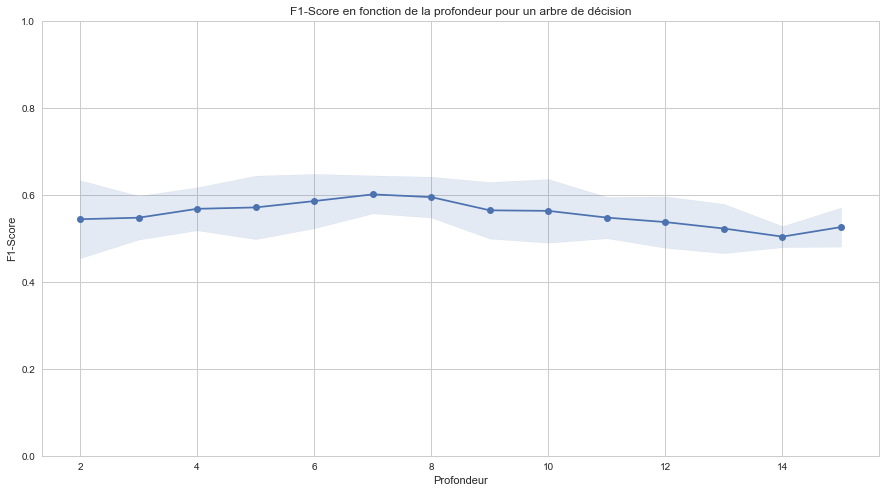

In [21]:
depths = [depth for depth in range(2, 16)]
performances_tree = []

for depth in depths:
    parameters = {"max_depth": depth}
    performances_depth, _ = stratified_cross_validation(X, y, DecisionTreeClassifier, parameters, cv=5)
    performances_tree.append(np.array(performances_depth))

plt.figure(figsize=(15, 8))
plot_performance(depths, performances_tree)
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.xlabel("Profondeur")
plt.title("F1-Score en fonction de la profondeur pour un arbre de décision")
plt.show()

## Et la Random Forest ?

On s'intéresse maintenant à la Random Forest. On souhaite mesurer la même chose que pour l'arbre.

**Consigne** : reproduire la même étude, mais avec une Random Forest de 50 arbres.

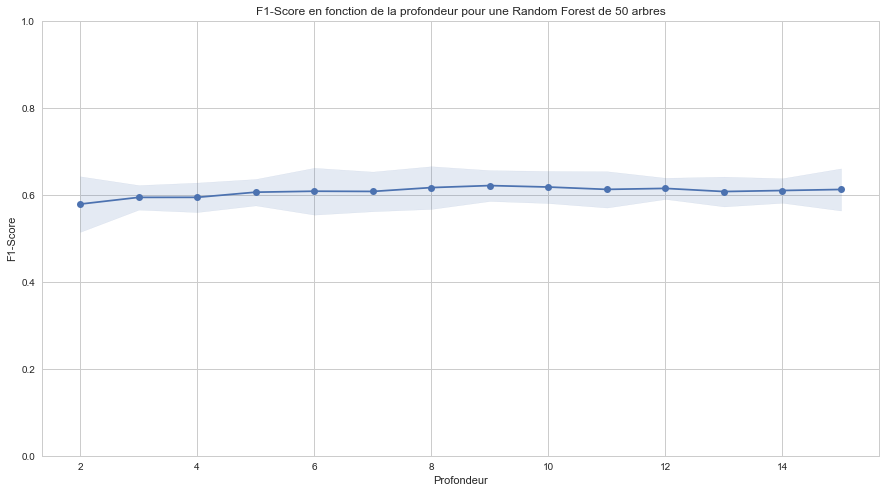

In [22]:
from sklearn.ensemble import RandomForestClassifier
depths = [depth for depth in range(2, 16)]
performances_forest = []

for depth in depths:
    parameters = {"n_estimators": 50, "max_depth": depth}
    performances_depth, _ = stratified_cross_validation(X, y, RandomForestClassifier, parameters, cv=5)
    performances_forest.append(np.array(performances_depth))

plt.figure(figsize=(15, 8))
plot_performance(depths, performances_forest)
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.xlabel("Profondeur")
plt.title("F1-Score en fonction de la profondeur pour une Random Forest de 50 arbres")
plt.show()

**Consigne** : Afficher sur le même graphique, avec une légende, les performances pour un arbre et pour une Random Forest.

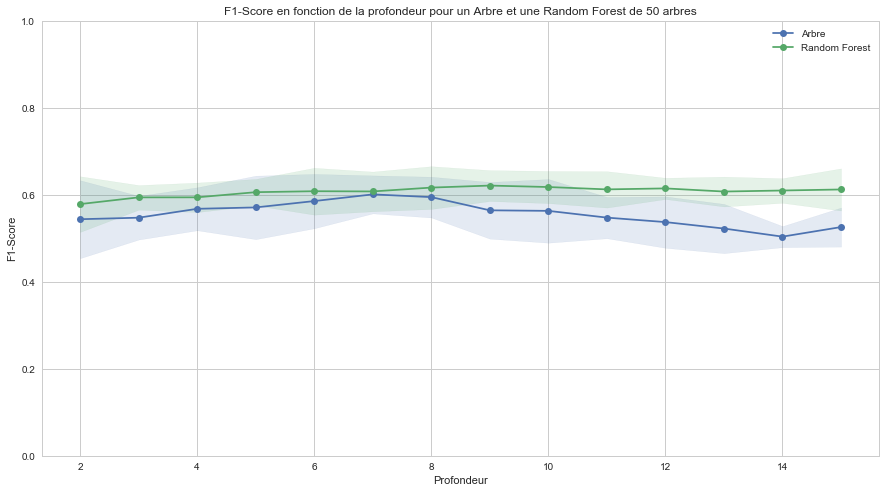

In [23]:
plt.figure(figsize=(15, 8))
plot_performance(depths, performances_tree, color=sns.color_palette()[0], label="Arbre")
plot_performance(depths, performances_forest, color=sns.color_palette()[1], label="Random Forest")
plt.ylim(0, 1)
plt.ylabel("F1-Score")
plt.xlabel("Profondeur")
plt.title("F1-Score en fonction de la profondeur pour un Arbre et une Random Forest de 50 arbres")
plt.legend()
plt.show()

## Et maintenant ?

Il existe d'autres hyperparamètres important dans ces modèles. Reproduire les études, et comparer les performances entre arbres et Random Forest voire Extra-Trees.